In [1]:
!pip install streamlit pyngrok  pillow


In [3]:
!pip install  opencv-python numpy torch torchvision  matplotlib tqdm pyngrok


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   - -------------------------------------- 6.0/204.1 MB 30.7 MB/s eta 0:00:07
   -- ------------------------------------- 12.8/204.1 MB 30.9 MB/s eta 0:00:07
   --- ------------------------------------ 19.7/204.1 MB 31.8 MB/s eta 0:00:06
   ----- ---------------------------------- 26.2/204.1 MB 31.9 MB/s eta 0:00:06
   ------ --------------------------------- 33.0/204.1 MB 32.3 MB/s eta 0:00:06
   ------- -------------------------------- 40.1/204.1 MB 32.3 MB/s eta 0:00:06
   --------- ------------------------------ 47.2/204.1 MB 32.6 MB/s eta 0:00:05
   ---------- ----------------------------- 54.3/204.1 MB 32.6 MB/s eta 0:00:05
   ------------ --------------------------- 61.3/204.1 MB 32.8 MB/s eta 0:00:

In [5]:
!pip install tensorflow

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from pyngrok import ngrok
import os
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet101
import os
import numpy as np
import cv2

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
EPOCHS = 30
BATCH_SIZE = 8

# Function to load and preprocess images
def load_image(image_path):
    image_path = image_path.numpy().decode("utf-8")  # Convert Tensor to string
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize
    return img.astype(np.float32)

# Function to load and preprocess masks
def load_mask(mask_path):
    mask_path = mask_path.numpy().decode("utf-8")  # Convert Tensor to string
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Error loading mask: {mask_path}")
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = mask / 255.0  # Normalize
    return mask.astype(np.float32)

# Function to create a dataset
def create_dataset(image_folder, mask_folder):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    image_paths = [os.path.join(image_folder, f) for f in image_files]
    mask_paths = [os.path.join(mask_folder, f) for f in mask_files]

    # Convert to TensorFlow Dataset
    def load_data(img_path, mask_path):
        img, mask = tf.py_function(func=load_image, inp=[img_path], Tout=tf.float32), \
                    tf.py_function(func=load_mask, inp=[mask_path], Tout=tf.float32)

        img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

# Attention block for enhanced feature extraction
def attention_block(x, g):
    """ Attention mechanism for better feature selection """
    x1 = layers.Conv2D(256, (1, 1), padding="same")(x)
    g1 = layers.Conv2D(256, (1, 1), padding="same")(g)
    psi = layers.Add()([x1, g1])
    psi = layers.Activation("relu")(psi)
    psi = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(psi)
    x = layers.Multiply()([x, psi])
    return x

# Define PlaneNet model with ResNet-101
def build_planenet():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    base_model = ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)
    base_model.trainable = False  # Freeze the ResNet101 layers

    # Extracting feature maps from different levels
    skip1 = base_model.get_layer("conv1_relu").output  # 128x128
    skip2 = base_model.get_layer("conv2_block3_out").output  # 64x64
    skip3 = base_model.get_layer("conv3_block4_out").output  # 32x32
    skip4 = base_model.get_layer("conv4_block23_out").output  # ✅ Corrected layer, 16x16

    bottleneck = base_model.get_layer("conv5_block3_out").output  # 8x8
    
    # Decoder with Attention Mechanism
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same", activation="relu")(bottleneck)
    x = layers.Concatenate()([x, attention_block(x, skip4)])

    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, attention_block(x, skip3)])

    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, attention_block(x, skip2)])

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Concatenate()([x, attention_block(x, skip1)])

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Train function with validation split
def train_planenet(image_folder, mask_folder):
    dataset = create_dataset(image_folder, mask_folder)
    
    # Split dataset into training (80%) and validation (20%)
    dataset_size = sum(1 for _ in dataset)
    train_size = int(0.8 * dataset_size)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    # Validate dataset
    for images, masks in train_dataset.take(1):
        print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")

    # Build model
    model = build_planenet()
    model.summary()

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("planenet_resnet101_best_model.h5", monitor="loss", save_best_only=True)
    ]

    # Train model with validation
    model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks)
    
    # Save final model
    model.save("planenet_resnet101_final_model.h5")

    return model

# Main function
def main():
    
    image_folder = r"C:\Users\KEERTHI KRISHANA\Downloads\raw_image"
    mask_folder = r"C:\Users\KEERTHI KRISHANA\Downloads\ground_truth"
    
    model = train_planenet(image_folder, mask_folder)

if __name__ == "__main__":
    main()


Image batch shape: (8, 256, 256, 3), Mask batch shape: (8, 256, 256, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 55,953,797 (213.45 MB)

 Trainable params: 13,295,621 (50.72 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5934 - loss: 0.6944

24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.5954 - loss: 0.6936 - val_accuracy: 0.7757 - val_loss: 0.5355
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7769 - loss: 0.5145

24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.7777 - loss: 0.5128 - val_accuracy: 0.8081 - val_loss: 0.4203
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8068 - loss: 0.4435

24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.8076 - loss: 0.4418 - val_accuracy: 0.8122 - val_loss: 0.3970
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8264 - loss: 0.4093

24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.8271 - loss: 0.4078 - val_accuracy: 0.8214 - val_loss: 0.3947
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8367 - loss: 0.3950

24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.8374 - loss: 0.3933 - val_accuracy: 0.8354 - val_loss: 0.3726
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8512 - loss: 0.3664

24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.8519 - loss: 0.3646 - val_accuracy: 0.8554 - val_loss: 0.3300
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8613 - loss: 0.3471

24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.8619 - loss: 0.3455 - val_accuracy: 0.8708 - val_loss: 0.3005
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8688 - loss: 0.3259

24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8694 - loss: 0.3243 - val_accuracy: 0.8782 - val_loss: 0.2882
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8739 - loss: 0.3147

24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.8744 - loss: 0.3133 - val_accuracy: 0.8854 - val_loss: 0.2715
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8762 - loss: 0.3024

24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8768 - loss: 0.3010 - val_accuracy: 0.8882 - val_loss: 0.2626
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8822 - loss: 0.2908

24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8827 - loss: 0.2896 - val_accuracy: 0.8892 - val_loss: 0.2613
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8843 - loss: 0.2871

24/24 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.8847 - loss: 0.2859 - val_accuracy: 0.8882 - val_loss: 0.2678
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8847 - loss: 0.2862

24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.8852 - loss: 0.2849 - val_accuracy: 0.8865 - val_loss: 0.2688
Epoch 14/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8851 - loss: 0.2849

24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8856 - loss: 0.2836 - val_accuracy: 0.8763 - val_loss: 0.2907
Epoch 15/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8909 - loss: 0.2770

24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8914 - loss: 0.2755 - val_accuracy: 0.8769 - val_loss: 0.2958
Epoch 16/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8933 - loss: 0.2705

24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.8938 - loss: 0.2692 - val_accuracy: 0.8696 - val_loss: 0.3192
Epoch 17/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8955 - loss: 0.2698

24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8960 - loss: 0.2682 - val_accuracy: 0.8723 - val_loss: 0.3263
Epoch 18/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8961 - loss: 0.2671

24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.8966 - loss: 0.2656 - val_accuracy: 0.8720 - val_loss: 0.3240
Epoch 19/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8989 - loss: 0.2607

24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.8994 - loss: 0.2592 - val_accuracy: 0.8798 - val_loss: 0.3035
Epoch 20/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9004 - loss: 0.2517

24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9008 - loss: 0.2503 - val_accuracy: 0.8764 - val_loss: 0.3203
Epoch 21/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.9016 - loss: 0.2528 - val_accuracy: 0.8715 - val_loss: 0.3431
Epoch 22/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9016 - loss: 0.2550

24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9021 - loss: 0.2534 - val_accuracy: 0.8699 - val_loss: 0.3484
Epoch 23/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9039 - loss: 0.2527

24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9044 - loss: 0.2510 - val_accuracy: 0.8765 - val_loss: 0.3312
Epoch 24/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9064 - loss: 0.2420

24/24 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9070 - loss: 0.2404 - val_accuracy: 0.8863 - val_loss: 0.3051
Epoch 25/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9076 - loss: 0.2352

24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9081 - loss: 0.2339 - val_accuracy: 0.8946 - val_loss: 0.2723
Epoch 26/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9092 - loss: 0.2258

24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.9096 - loss: 0.2244 - val_accuracy: 0.8919 - val_loss: 0.2837
Epoch 27/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9114 - loss: 0.2260

24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9119 - loss: 0.2246 - val_accuracy: 0.8910 - val_loss: 0.2994
Epoch 28/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9104 - loss: 0.2245 - val_accuracy: 0.8920 - val_loss: 0.2935
Epoch 29/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9110 - loss: 0.2235

24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.9114 - loss: 0.2222 - val_accuracy: 0.8911 - val_loss: 0.2995
Epoch 30/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9106 - loss: 0.2225 - val_accuracy: 0.8877 - val_loss: 0.3141


In [21]:
# Load the trained model
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("planenet_resnet101_final_model.h5")

In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def iou_score(y_true, y_pred):
    """Calculate Intersection over Union (IoU) score."""
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def overlay_segmentation(original_img, mask):
    """
    Overlay segmentation mask on the original image.
    
    - Background (0) → Green (0,255,0)
    - Foreground (1) → Blue (255,0,0)
    
    Returns:
    - Image with segmentation mask overlay
    """
    overlay = original_img.copy()
    
    # Green for background
    overlay[mask == 0] = (
        0.5 * overlay[mask == 0] + 0.5 * np.array([0, 255, 0])
    ).astype(np.uint8)

    # Blue for foreground
    overlay[mask == 1] = (
        0.5 * overlay[mask == 1] + 0.5 * np.array([255, 0, 0])
    ).astype(np.uint8)

    return overlay

def evaluate_prediction(model_path, test_image_path, ground_truth_path=None):
    """
    Load a trained model, predict on a test image, visualize the output, and compute evaluation metrics (if ground truth is available).
    
    Parameters:
    - model_path: Path to the trained model.
    - test_image_path: Path to the test image.
    - ground_truth_path: Path to the ground truth mask (optional).
    """
    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess the test image
    img = cv2.imread(test_image_path)
    if img is None:
        raise ValueError(f"Error loading test image: {test_image_path}")
    
    img = cv2.resize(img, (256, 256))  # Resize
    img_norm = img / 255.0  # Normalize for model prediction
    img_input = np.expand_dims(img_norm, axis=0)  # Add batch dimension

    # Make prediction
    pred_mask = model.predict(img_input)[0]  # Remove batch dimension
    pred_mask = np.squeeze(pred_mask)  # Remove extra dimensions if any
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to binary mask (0 or 1)

    # Convert image back to uint8 for visualization
    img_uint8 = (img_norm * 255).astype(np.uint8)

    # Overlay segmentation on the original image
    overlayed_img = overlay_segmentation(img_uint8, pred_mask)

    # Check if ground truth is provided
    metrics_available = ground_truth_path and os.path.exists(ground_truth_path)
    
    if metrics_available:
        # Load ground truth mask
        gt_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None:
            raise ValueError(f"Error loading ground truth mask: {ground_truth_path}")
        
        gt_mask = cv2.resize(gt_mask, (256, 256))
        gt_mask = (gt_mask > 127).astype(np.uint8)  # Convert grayscale to binary mask

        # Compute evaluation metrics
        acc = accuracy_score(gt_mask.flatten(), pred_mask.flatten())
        precision = precision_score(gt_mask.flatten(), pred_mask.flatten(), zero_division=1)
        recall = recall_score(gt_mask.flatten(), pred_mask.flatten(), zero_division=1)
        f1 = f1_score(gt_mask.flatten(), pred_mask.flatten(), zero_division=1)
        iou = iou_score(gt_mask, pred_mask)

        # Print metrics
        print(f"🔹 Accuracy: {acc:.4f}")
        print(f"🔹 Precision: {precision:.4f}")
        print(f"🔹 Recall: {recall:.4f}")
        print(f"🔹 F1-score: {f1:.4f}")
        print(f"🔹 IoU: {iou:.4f}")
    
    # Plot results
    plt.figure(figsize=(15, 5))

    # Show original image
    plt.subplot(1, 3 if metrics_available else 2, 1)
    plt.imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title("Original Image")
    plt.axis("off")

    if metrics_available:
        # Show ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Show overlayed image
        plt.subplot(1, 3, 3)
    else:
        # Show overlayed image without ground truth
        plt.subplot(1, 2, 2)
    
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.title("Predicted Segmentation Overlay")
    plt.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
🔹 Accuracy: 0.8807
🔹 Precision: 0.6799
🔹 Recall: 0.9558
🔹 F1-score: 0.7946
🔹 IoU: 0.6592


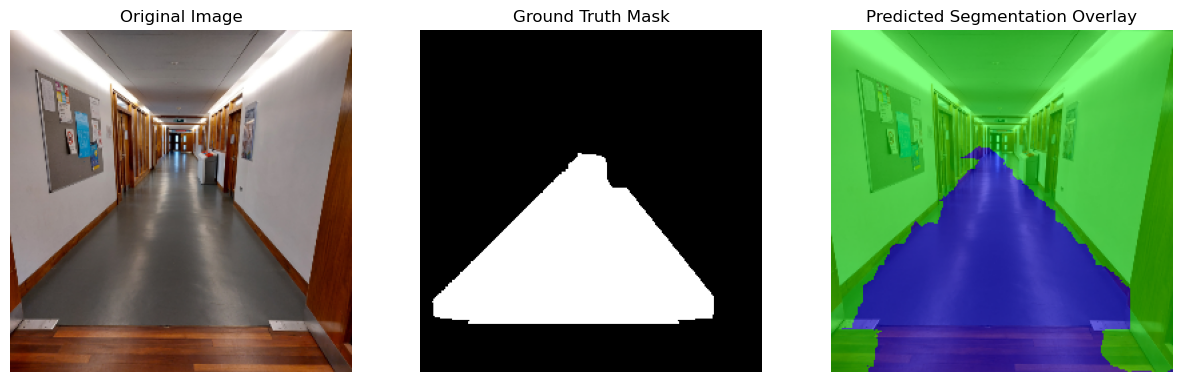

In [65]:
test_image_path = r"C:\Users\KEERTHI KRISHANA\Downloads\raw_image\frame_001.png"
ground_truth_path = r"C:\Users\KEERTHI KRISHANA\Downloads\ground_truth\frame_001_mask.png"

evaluate_prediction("planenet_resnet101_best_model.h5", test_image_path, ground_truth_path)


In [86]:
file_path = r"C:\Users\KEERTHI KRISHANA\Downloads\app.py"

script_content = """\
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ========== SET PARAMETERS ==========
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Load the model
MODEL_PATH = r"C:\\Users\\KEERTHI KRISHANA\\Downloads\\planenet_resnet101_final_model.h5"

@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model(MODEL_PATH, compile=False)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        return model
    except Exception as e:
        st.error(f"Error loading model: {str(e)}")
        return None

model = load_model()

# ========== COLOR MAPS ==========
WALL_COLOR = np.array([0, 255, 0], dtype=np.uint8)  # Green for walls
FLOOR_COLOR = np.array([255, 0, 0], dtype=np.uint8)  # Red for floor

# ========== IoU METRIC ==========
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

# ========== FUNCTION TO APPLY MASK OVERLAY ==========
def overlay_segmentation(original_img, mask):
    overlay = original_img.copy()
    overlay[mask == 0] = (0.5 * overlay[mask == 0] + 0.5 * WALL_COLOR).astype(np.uint8)
    overlay[mask == 1] = (0.5 * overlay[mask == 1] + 0.5 * FLOOR_COLOR).astype(np.uint8)
    return overlay

# ========== PREDICTION FUNCTION ==========
def predict_image(image, ground_truth_path=None):
    try:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        input_img = np.expand_dims(img_resized, axis=0)

        # Model Prediction
        pred_mask = model.predict(input_img, verbose=0)[0]
        pred_mask = np.squeeze(pred_mask)
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Convert original image back to uint8
        img_uint8 = (img_resized * 255).astype(np.uint8)

        # Overlay segmentation
        overlayed_img = overlay_segmentation(img_uint8, pred_mask)

        # If ground truth is provided, compute metrics
        if ground_truth_path and os.path.exists(ground_truth_path):
            gt_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
            gt_mask = cv2.resize(gt_mask, (IMG_WIDTH, IMG_HEIGHT))
            gt_mask = (gt_mask > 127).astype(np.uint8)

            acc = accuracy_score(gt_mask.flatten(), pred_mask.flatten())
            precision = precision_score(gt_mask.flatten(), pred_mask.flatten(), zero_division=1)
            recall = recall_score(gt_mask.flatten(), pred_mask.flatten(), zero_division=1)
            f1 = f1_score(gt_mask.flatten(), pred_mask.flatten(), zero_division=1)
            iou = iou_score(gt_mask, pred_mask)

            return img_uint8, pred_mask, overlayed_img, (acc, precision, recall, f1, iou)
        
        return img_uint8, pred_mask, overlayed_img, None
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")
        return None, None, None, None

# ========== STREAMLIT UI ==========
st.title("Room Segmentation")

if model is None:
    st.error("Model failed to load. Please check the model file path.")
else:
    # Upload Image
    uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png", "jpeg"])
    ground_truth_file = st.file_uploader("Upload ground truth mask (optional)", type=["png"])

    if uploaded_file:
        try:
            image = np.array(Image.open(uploaded_file))
            st.image(image, caption="Uploaded Image", use_column_width=True)

            if st.button("Predict"):
                # Save ground truth temporarily
                gt_path = None
                if ground_truth_file:
                    gt_path = "temp_gt.png"
                    with open(gt_path, "wb") as f:
                        f.write(ground_truth_file.getbuffer())

                orig, mask, overlayed, metrics = predict_image(image, gt_path)

                if orig is not None:
                    col1, col2 = st.columns(2)
                    with col1:
                        st.image(orig, caption="Original Image", use_column_width=True)
                    with col2:
                        st.image(overlayed, caption="Predicted Segmentation Overlay", use_column_width=True)

                    if metrics:
                        st.subheader("Performance Metrics")
                        st.metric("Accuracy", f"{metrics[0]:.4f}")
                        st.metric("Precision", f"{metrics[1]:.4f}")
                        st.metric("Recall", f"{metrics[2]:.4f}")
                        st.metric("F1-score", f"{metrics[3]:.4f}")
                        st.metric("IoU", f"{metrics[4]:.4f}")

                # Clean up temporary file
                if gt_path and os.path.exists(gt_path):
                    os.remove(gt_path)

        except Exception as e:
            st.error(f"Image processing error: {str(e)}")

    # Webcam capture
    if st.button("Capture from Webcam"):
        try:
            cap = cv2.VideoCapture(0)
            if not cap.isOpened():
                st.error("Could not open webcam")
            else:
                ret, frame = cap.read()
                cap.release()

                if ret:
                    orig, mask, overlayed, _ = predict_image(frame)
                    if orig is not None:
                        col1, col2 = st.columns(2)
                        with col1:
                            st.image(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
                                    caption="Captured Image", 
                                    use_column_width=True)
                        with col2:
                            st.image(overlayed, 
                                    caption="Overlayed Result", 
                                    use_column_width=True)
                else:
                    st.error("Failed to capture image from webcam")
        except Exception as e:
            st.error(f"Webcam error: {str(e)}")
"""

# Save the script
with open(file_path, "w", encoding="utf-8") as f:
    f.write(script_content)

print(f"File saved as {file_path}")

File saved as C:\Users\KEERTHI KRISHANA\Downloads\app.py


In [92]:
!streamlit run app.py --server.port 8513 --browser.serverAddress localhost


^C
